In [30]:
import pandas as pd
import requests
import numpy as np
import itertools
import talib
import quandl
import tensorflow as tf
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import time
import tushare as ts
from tensorflow.contrib.layers.python.layers.initializers import xavier_initializer
%matplotlib inline

In [44]:
# select two stocks which passed co-intergration test (cheating exist)
quandl.ApiConfig.api_key = 'CTq2aKvtCkPPgR4L_NFs'
data=pd.DataFrame()
for s in ['JNPR','HPQ']:
    stock=quandl.get_table('WIKI/PRICES', date={'gte':'2002-01-01'}, ticker=s)
    stock.index=stock['date']
    data[s+'_p']=stock.adj_close
    data[s+'_v']=np.log(stock.adj_volume)

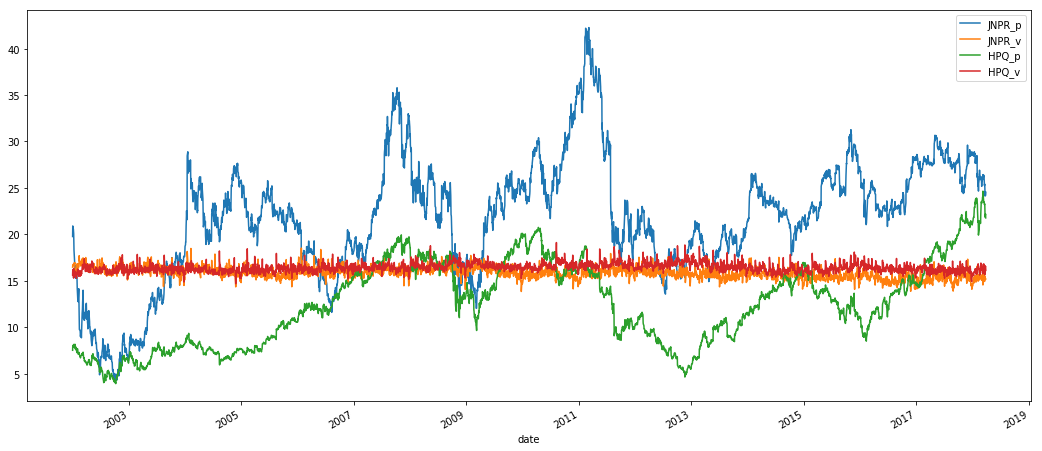

In [45]:
data.plot(figsize=(18,8))

In [46]:
data=data.dropna(axis=1)
data.head()

,JNPR_p,JNPR_v,HPQ_p,HPQ_v
date,,,,
2002-01-02,19.762895,16.467801,7.517142,15.635064
2002-01-03,20.903610,16.721778,7.971990,16.179228
2002-01-04,20.466336,16.686654,8.041432,15.750100
2002-01-07,20.570902,16.666379,7.992822,15.777702
2002-01-08,20.342759,16.617694,7.909491,15.321209


In [79]:
# Use SP500 continous future contract as baseline
sp500_baseline=quandl.get("CHRIS/CME_SP1")['Last'].dropna()

In [47]:
def generate_tech_data(pair):
    p1_c,v1_c,p2_c,v2_c=tuple(pair.columns)
    s1_name,s2_name=p1_c.split('_')[0],p2_c.split('_')[0]
    p1=pair[p1_c].values
    p2=pair[p2_c].values
    spread=p1-p2
    v1=pair[v1_c].values
    v2=pair[v2_c].values
    sample = pair.copy()
    sample[s1_name + '_mom'] = talib.MOM(p1)
    sample[s1_name + '_macd'], sample[s1_name + '_macd_sig'], sample[s1_name + '_macd_hist'] = talib.MACD(p1)
    sample[s1_name + '_rsi'] = talib.RSI(p1, timeperiod=10)
    sample[s1_name + '_cmo'] = talib.CMO(p1)
    sample[s2_name + '_mom'] = talib.MOM(p2)
    sample[s2_name + '_macd'], sample[s2_name + '_macd_sig'], sample[s2_name + '_macd_hist'] = talib.MACD(p2)
    sample[s2_name + '_rsi'] = talib.RSI(p2, timeperiod=10)
    sample[s2_name + '_cmo'] = talib.CMO(p2)
    sample['spread'] = spread
    sample['diff'] = sample['spread'] / sample['spread'].shift(1)
#     spread=p1-p2
#     data['spread'+'_mom'] = talib.MOM(spread)
#     data['spread'+'_macd'], data['spread'+'_macd_sig'], data['spread'+'_macd_hist'] = talib.MACD(spread)
#     data['spread'+'_rsi'] = talib.RSI(spread,timeperiod=10)
#     data['spread'+'_cmo'] = talib.CMO(spread)
    sample=sample.dropna()
    return sample
z_score= lambda x:(x-x.mean(axis=0))/x.std(axis=0)

In [48]:
full_features=generate_tech_data(data)

In [49]:
full_features.head()

,JNPR_p,JNPR_v,HPQ_p,HPQ_v,JNPR_mom,JNPR_macd,JNPR_macd_sig,JNPR_macd_hist,JNPR_rsi,JNPR_cmo,HPQ_mom,HPQ_macd,HPQ_macd_sig,HPQ_macd_hist,HPQ_rsi,HPQ_cmo,spread,diff
date,,,,,,,,,,,,,,,,,,
2002-02-20,9.610528,17.114199,6.881744,15.490792,-3.232027,-2.282527,-2.020381,-0.262146,18.663303,-59.516840,-0.545123,-0.252159,-0.220186,-0.031973,32.565208,-24.894429,2.728784,-0.058857
2002-02-21,9.163747,16.891675,6.756747,15.567715,-3.973492,-2.333322,-2.082970,-0.250353,17.235192,-61.732422,-0.482625,-0.268590,-0.229867,-0.038723,29.356646,-29.775461,2.407000,-0.321784
2002-02-22,8.992640,16.963174,6.697721,15.601654,-3.754855,-2.360178,-2.138411,-0.221767,16.691685,-62.577136,-0.524290,-0.283111,-0.240516,-0.042595,27.913612,-32.022125,2.294919,-0.112081
2002-02-25,9.410902,16.579613,6.937297,15.841222,-3.792879,-2.320956,-2.174920,-0.146036,23.264109,-53.648756,-0.145829,-0.272150,-0.246843,-0.025307,40.994081,-15.825049,2.473605,0.178686
2002-02-26,9.686575,16.669812,6.947714,16.100400,-4.458296,-2.241786,-2.188293,-0.053493,27.455376,-47.884210,-0.291658,-0.259630,-0.249400,-0.010230,41.506831,-15.163501,2.738861,0.265257


In [122]:
# Prepare data
baseline_diff=(sp500_baseline/sp500_baseline.shift(1))[full_features.index[0]:]
price=data[full_features.index[0]:]
f_data=full_features
z_data=full_features['diff']
feature_number=f_data.shape[1]
# tao=0.8
target_profit=2

In [123]:
class DRL_PairsTrading(object):
    def __init__(self, feature_number, dense_units_list=[1024, 768, 512, 256], rnn_hidden_layer_number=4, rnn_hidden_units_number=128, learning_rate=0.001):
        tf.reset_default_graph()
        self.f = tf.placeholder(dtype=tf.float32, shape=[None, feature_number], name='environment_features')
        self.z = tf.placeholder(dtype=tf.float32, shape=[None, 1], name='environment_return')
        self.c = tf.placeholder(dtype=tf.float32, shape=[], name='environment_fee')
        self.dropout_keep_prob = tf.placeholder(dtype=tf.float32, shape=[], name='dropout_keep_prob')
        self.hidden_rnn_init_state = tf.placeholder(tf.float32, [rnn_hidden_layer_number, 1, rnn_hidden_units_number], name='hidden_rnn_initial_state')
        self._state_per_layer_list = tf.unstack(self.hidden_rnn_init_state, axis=0)
        self.rnn_tuple_state = tuple(self._state_per_layer_list)
        self.previous_rnn_output = tf.placeholder(dtype=tf.float32, shape=[1, rnn_hidden_units_number], name='previous_rnn_output')
        
        with tf.variable_scope('feed_forward', initializer=tf.contrib.layers.xavier_initializer(uniform=False), regularizer=tf.contrib.layers.l2_regularizer(0.01)):
            self.dense_output = self.f
            for u_number in dense_units_list:
                self.dense_output = self._add_dense_layer(self.dense_output, output_shape=u_number, drop_keep_prob=self.dropout_keep_prob)
            self.dense_output = self._add_dense_layer(self.dense_output, output_shape=rnn_hidden_units_number, drop_keep_prob=self.dropout_keep_prob)
        
        with tf.variable_scope('rnn', initializer=tf.contrib.layers.xavier_initializer(uniform=False), regularizer=tf.contrib.layers.l2_regularizer(0.01)):
            rnn_hidden_cells = [self._add_gru_cell(rnn_hidden_units_number)] * rnn_hidden_layer_number
            layered_cell = tf.contrib.rnn.MultiRNNCell(rnn_hidden_cells)
            self.zero_state = layered_cell.zero_state(1, dtype=tf.float32)
            rnn_input = tf.expand_dims(self.dense_output, axis=0)
            self.rnn_outputs, self.current_state = tf.nn.dynamic_rnn(layered_cell, initial_state=self.rnn_tuple_state, inputs=rnn_input)
            self.current_output = tf.reshape(self.rnn_outputs[0][-1], [1, rnn_hidden_units_number])
            self.rnn_outputs = tf.concat((self.previous_rnn_output, tf.unstack(self.rnn_outputs, axis=0)[0]), axis=0)
        with tf.variable_scope('action', initializer=tf.contrib.layers.xavier_initializer(uniform=False), regularizer=tf.contrib.layers.l2_regularizer(0.01)):
            self.action = tf.contrib.layers.fully_connected(num_outputs=1, inputs=self.rnn_outputs, activation_fn=tf.tanh)
        with tf.variable_scope('reward'):
            self.log_reward_t = tf.log(self.z) * self.action[:-1] - self.c * tf.abs(self.action[1:] - self.action[:-1])
            self.cum_log_reward = tf.reduce_sum(self.log_reward_t)
            self.reward_t = tf.exp(self.log_reward_t)
            self.cum_reward = tf.reduce_prod(self.reward_t)
        with tf.variable_scope('train'):
            optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = optimizer.minimize(-self.cum_reward)
        self.init_op = tf.global_variables_initializer()
        self.saver = tf.train.Saver()
        self.session = tf.Session()
    
    def init_model(self):
        self.session.run(self.init_op)
    
    def get_rnn_zero_state(self):
        zero_states = self.session.run([self.zero_state])[0]
        return zero_states
    
    def _add_dense_layer(self, inputs, output_shape, drop_keep_prob, act=tf.nn.tanh):
        output = tf.contrib.layers.fully_connected(activation_fn=act, num_outputs=output_shape, inputs=inputs)
        output = tf.nn.dropout(output, drop_keep_prob)
        return output
    
    def _add_gru_cell(self, units_number):
        return tf.contrib.rnn.GRUCell(num_units=units_number)
    
    def build_feed_dict(self, batch_F, batch_Z, keep_prob, fee, rnn_hidden_init_state, previous_output):
        return {
            self.f: batch_F,
            self.z: batch_Z,
            self.dropout_keep_prob: keep_prob,
            self.hidden_rnn_init_state: rnn_hidden_init_state,
            self.previous_rnn_output: previous_output,
            self.c: fee
        }
    
    def train(self, feed):
        self.session.run([self.train_op], feed_dict=feed)
    
    def load_model(self, model_file='./trade_model_checkpoint/trade_model'):
        self.saver.restore(self.session, model_file)
    
    def save_model(self, model_path='./trade_model_checkpoint'):
        if not os.path.exists(model_path):
            os.mkdir(model_path)
        model_file = model_path + '/trade_model'
        self.saver.save(self.session, model_file)
    
    def trade(self, feed):
        rewards, cum_reward, actions, current_state, current_rnn_output = self.session.run([self.log_reward_t, self.cum_log_reward, self.action, self.current_state, self.current_output], feed_dict=feed)
        return rewards, cum_reward, actions, current_state, current_rnn_output

In [124]:
model= DRL_PairsTrading(feature_number=feature_number)

In [125]:
def batch_nomorlize(sample):
    return z_score(sample)

In [250]:
model.init_model()
train_period=9
sequence_length=400
max_epoch=200
fee=1e-1
hidden_initial_state=model.get_rnn_zero_state()
current_rnn_output=hidden_initial_state[-1]
for e in range(max_epoch):
    train_actions=np.zeros(train_period*sequence_length)
    train_reward=np.zeros(train_period*sequence_length)
    baseline=baseline_diff[:(train_period*sequence_length)]
    mean_cum_reward=[]
    for batch in range(train_period):
        batch_f=batch_nomorlize(f_data[(batch*sequence_length):(batch+1)*sequence_length])
        batch_z=np.expand_dims(z_data[(batch*sequence_length):(batch+1)*sequence_length],axis=1)
        feed=model.build_feed_dict(batch_F=batch_f,
                                   batch_Z=batch_z,
                                   keep_prob=0.8,
                                   fee=fee,
                                   rnn_hidden_init_state=hidden_initial_state,
                                   previous_output=current_rnn_output)
        model.train(feed)
        rewards, cum_reward, actions, hidden_initial_state, current_rnn_output=model.trade(feed)
        train_reward[(batch*sequence_length):(batch+1)*sequence_length]=rewards.flatten()
        train_actions[(batch*sequence_length):(batch+1)*sequence_length]=actions[:-1].flatten()
        mean_cum_reward.append(cum_reward.ravel())
    print("train_reward:", np.mean(mean_cum_reward))
    if np.mean(mean_cum_reward)>10: break

train_reward: 14.65358


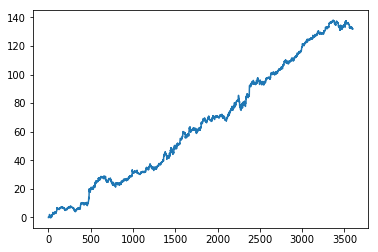

In [251]:
plt.plot(np.cumsum(train_reward))

In [252]:
# model.init_model()
test_f=batch_nomorlize(f_data[sequence_length*train_period:])
test_z=np.expand_dims(z_data[sequence_length*train_period:],axis=1)
# hidden_initial_state=model.get_rnn_zero_state()
# current_rnn_output=hidden_initial_state[-1]
feed=model.build_feed_dict(batch_F=test_f,
                                   batch_Z=test_z,
                                   keep_prob=1.0,
                                   fee=fee,
                                   rnn_hidden_init_state=hidden_initial_state,
                                   previous_output=current_rnn_output)
rewards, cum_reward, actions, hidden_initial_state, current_rnn_output=model.trade(feed)
print(cum_reward)

18.867058


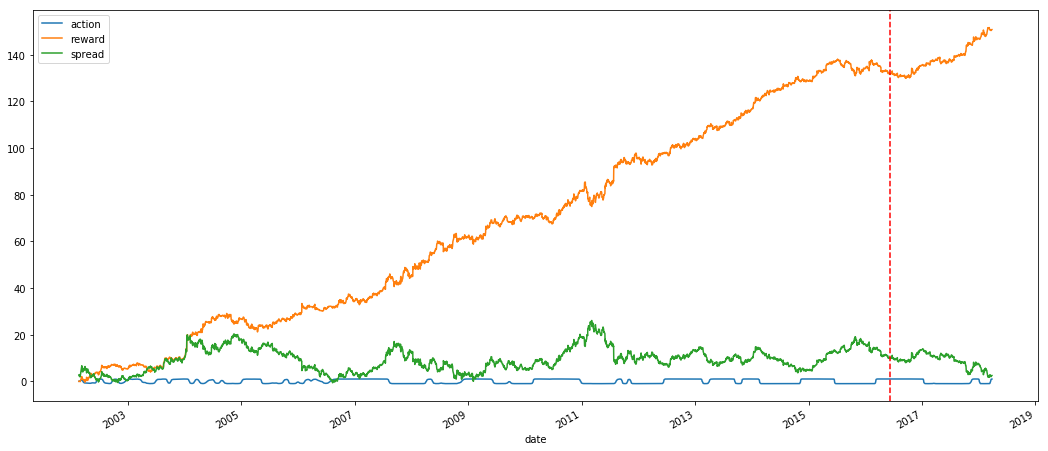

In [253]:
total_rewards=np.cumsum(np.concatenate((train_reward,rewards.flatten())))
total_actions=np.concatenate((train_actions,actions[:-1].flatten()))
total_spread=full_features['spread']
pd.DataFrame({'reward':total_rewards,'action':total_actions,'spread':total_spread},index=f_data.index).plot(figsize=(18,8))
plt.axvline(z_data[:train_period*sequence_length].index[-1],color='red',linestyle='--')
# The test result of 300 days seems OK,keeps the uptrend
# The output actions can be used in back testing